In [1]:
import os
import warnings
from dotenv import load_dotenv

import faiss
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_community.docstore.in_memory import InMemoryDocstore

In [2]:
# .env 로드
load_dotenv()
# os.getenv("OPENAI_API_KEY")

# 경고 무시
warnings.filterwarnings("ignore")

In [3]:
import os
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"

In [4]:
# 1. PDF 로드 및 FAISS 벡터 스토어 생성

In [5]:
# PDF 문서 로드
pdf_path = "SPRI_AI_Brief_2023년12월호_F.pdf"
loader = PyMuPDFLoader(pdf_path)
docs = loader.load()

print(f"총 {len(docs)}개의 페이지 로드됨")
print(f"첫 페이지 미리보기: {docs[0].page_content[:200]}...")

총 23개의 페이지 로드됨
첫 페이지 미리보기: 2023년 12월호...


In [6]:
# 텍스트 청킹
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
)

splits = text_splitter.split_documents(docs)
print(f"총 {len(splits)}개의 청크 생성됨")
print(f"첫 청크 미리보기: {splits[0].page_content[:200]}...")

총 43개의 청크 생성됨
첫 청크 미리보기: 2023년 12월호...


In [7]:
# FAISS 벡터 스토어 생성
embeddings = OpenAIEmbeddings()

vectorstore = FAISS.from_documents(
    documents=splits,
    embedding=embeddings
)

print("FAISS 벡터 스토어 생성 완료")

FAISS 벡터 스토어 생성 완료


In [8]:
# Retriever 설정
retriever = vectorstore.as_retriever(
    search_kwargs={"k": 4}
)

# 테스트 검색
test_docs = retriever.invoke("삼성전자 생성형 AI")
print(f"검색된 문서 수: {len(test_docs)}")
print(f"첫 번째 문서:\n{test_docs[0].page_content[:300]}...")

검색된 문서 수: 4
첫 번째 문서:
사내 소프트웨어 개발에 최적화
∙이미지 모델은 창의적인 이미지를 생성하고 기존 이미지를 원하는 대로 바꿀 수 있도록 지원하며 
저해상도 이미지의 고해상도 전환도 지원
n IT 전문지 테크리퍼블릭(TechRepublic)은 온디바이스 AI가 주요 기술 트렌드로 부상했다며, 
2024년부터 가우스를 탑재한 삼성 스마트폰이 메타의 라마(Llama)2를 탑재한 퀄컴 기기 및 구글 
어시스턴트를 적용한 구글 픽셀(Pixel)과 경쟁할 것으로 예상
☞ 출처 : 삼성전자, ‘삼성 AI 포럼’서 자체 개발 생성형 AI ‘삼성 가우스’ 공개, 20...


In [9]:
# 2. AgentState 및 기본 설정

In [10]:
from typing import Annotated, Sequence, TypedDict, Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# 문서 평가용 Pydantic 모델
class Grade(BaseModel):
    binary_score: str = Field(
        description="Response 'yes' if the document is relevant to the question or 'no' if it is not."
    )

# 기본 설정
MODEL_NAME = 'gpt-5-nano'
TEMPERATURE = 0

print("AgentState 및 설정 완료")

AgentState 및 설정 완료


In [11]:
# 3. LangGraph 노드 구현


In [12]:
# 3.1 retrieve 노드: 문서 검색
def retrieve(state: AgentState):
    print("==== [RETRIEVE] ====")
    messages = state["messages"]
    question = messages[0].content
    
    # FAISS로 문서 검색
    docs = retriever.invoke(question)
    
    # 검색된 문서를 문자열로 변환
    docs_content = "\n\n".join([doc.page_content for doc in docs])
    
    return {"messages": [HumanMessage(content=docs_content)]}

print("retrieve 노드 구현 완료")

retrieve 노드 구현 완료


In [13]:
# 3.2 grade_documents 조건부 엣지: 문서 품질 평가
def grade_documents(state: AgentState) -> Literal["generate", "rewrite"]:
    print("==== [GRADE DOCUMENTS] ====")
    
    model = ChatOpenAI(temperature=TEMPERATURE, model=MODEL_NAME, streaming=True)
    llm_with_tool = model.with_structured_output(Grade)
    
    prompt = PromptTemplate(
        template="""You are a strict grader assessing relevance of a retrieved document to a user question.

Retrieved document:
{context}

User question:
{question}

IMPORTANT: You must grade as relevant ONLY if:
1. The document contains SPECIFIC information that DIRECTLY answers the question
2. The document has concrete facts, names, numbers, or details related to the question
3. The question is NOT too broad or general

Grade as NOT relevant if:
- The question is too broad or vague (e.g., "Tell me about AI industry")
- The document only has tangentially related information
- The document doesn't contain specific answers to the question

Give a binary score 'yes' or 'no':""",
        input_variables=["context", "question"]
    )
    
    chain = prompt | llm_with_tool
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score
    
    if score == "yes":
        print("==== [DECISION: DOCS RELEVANT] ====")
        return "generate"
    else:
        print("==== [DECISION: DOCS NOT RELEVANT] ====")
        return "rewrite"

print("grade_documents 조건부 엣지 구현 완료")

grade_documents 조건부 엣지 구현 완료


In [14]:
# 3.3 rewrite 노드: 사용자에게 재질문 요청
def rewrite(state: AgentState):
    print("==== [REQUEST CLARIFICATION] ====")
    
    messages = state["messages"]
    question = messages[0].content
    
    # 사용자에게 더 구체적인 질문을 요청하는 메시지 생성
    clarification_message = f"""질문이 너무 광범위합니다: "{question}"

문서에서 구체적인 정보를 찾기 위해 질문을 더 명확히 해주세요.

예시:
- "SPRI AI Brief에서 다룬 특정 기업은?"
- "2023년 12월 AI 산업의 주요 동향은?"
- "삼성전자의 AI 관련 발표 내용은?"

더 구체적인 질문을 입력해주세요."""
    
    print(clarification_message)
    
    # END로 종료하여 사용자 입력 대기
    return {"messages": [HumanMessage(content=clarification_message)]}

print("rewrite 노드 구현 완료")

rewrite 노드 구현 완료


In [15]:
# 3.4 generate 노드: 최종 답변 생성
def generate(state: AgentState):
    print("==== [GENERATE ANSWER] ====")
    
    messages = state["messages"]
    question = messages[0].content
    docs = messages[-1].content
    
    prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Answer in Korean.

Question: {question} 
Context: {context} 
Answer:""",
        input_variables=["question", "context"]
    )
    
    llm = ChatOpenAI(model=MODEL_NAME, temperature=TEMPERATURE, streaming=True)
    rag_chain = prompt | llm | StrOutputParser()
    
    response = rag_chain.invoke({"context": docs, "question": question})
    
    return {"messages": [HumanMessage(content=response)]}

print("generate 노드 구현 완료")

generate 노드 구현 완료


# 4. StateGraph 구성 및 컴파일

In [16]:
from langgraph.graph import END, StateGraph, START

# StateGraph 생성
workflow = StateGraph(AgentState)

# 노드 추가 (grade_documents는 노드가 아님!)
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

# 엣지 연결
workflow.add_edge(START, "retrieve")
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,  # 조건 함수로만 사용
    {
        "generate": "generate",
        "rewrite": "rewrite"
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", END)  # rewrite 후 END로 변경 (사용자 입력 대기)

# 그래프 컴파일
graph = workflow.compile()

print("StateGraph 컴파일 완료")

StateGraph 컴파일 완료


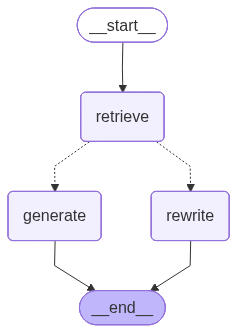

In [17]:
# 그래프 시각화
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

# 5. 테스트

In [18]:
# 5.1 대화형 RAG 시스템
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "interactive-1"}
)

print("=" * 60)
print("RAG 시스템 시작 (종료: 'quit', 'exit', 'q')")
print("=" * 60)

while True:
    # 사용자 입력 받기
    user_question = input("\n질문: ").strip()
    
    # 종료 조건
    if user_question.lower() in ['quit', 'exit', 'q', '종료']:
        print("\n시스템을 종료합니다.")
        break
    
    if not user_question:
        print("질문을 입력해주세요.")
        continue
    
    # 그래프 실행
    inputs = {
        "messages": [HumanMessage(content=user_question)]
    }
    
    try:
        result = graph.invoke(inputs, config=config)
        print("\n" + "=" * 60)
        print("답변:")
        print(result["messages"][-1].content)
        print("=" * 60)
    except Exception as e:
        print(f"\n오류 발생: {e}")

RAG 시스템 시작 (종료: 'quit', 'exit', 'q')
==== [RETRIEVE] ====
==== [RETRIEVE] ====
==== [GRADE DOCUMENTS] ====
==== [GRADE DOCUMENTS] ====
==== [DECISION: DOCS RELEVANT] ====
==== [GENERATE ANSWER] ====
==== [DECISION: DOCS RELEVANT] ====
==== [GENERATE ANSWER] ====

답변:
삼성이 개발한 생성형 AI의 이름은 '삼성 가우스'입니다. 언어, 코드, 이미지의 3개 모델로 구성되며 온디바이스에서 작동하도록 설계되었습니다.

답변:
삼성이 개발한 생성형 AI의 이름은 '삼성 가우스'입니다. 언어, 코드, 이미지의 3개 모델로 구성되며 온디바이스에서 작동하도록 설계되었습니다.
==== [RETRIEVE] ====
==== [RETRIEVE] ====
==== [GRADE DOCUMENTS] ====
==== [GRADE DOCUMENTS] ====
==== [DECISION: DOCS RELEVANT] ====
==== [GENERATE ANSWER] ====
==== [DECISION: DOCS RELEVANT] ====
==== [GENERATE ANSWER] ====

답변:
다음은 주어진 맥락을 바탕으로 한 AI에 대한 간단한 정리입니다.

- AI란 무엇인가
  - 인공지능은 데이터를 바탕으로 패턴을 분석하고, 예측하거나 자동으로 작업을 수행하는 컴퓨터 시스템을 말합니다.

- AI 에이전트란
  - 자연어를 이해하고 사용자에 대한 충분한 지식을 바탕으로 다양한 작업을 수행하는 소프트웨어를 말합니다.
  - 사람처럼 대화하고, 사용자 맞춤의 지원을 제공하는 개인 비서 역할을 하거나, 특정 업무를 자동화하는 도구로 기능합니다.
  - 예) 여행 계획 시 예산에 맞는 호텔 제안, 관심사에 맞춘 활동 추천, 생활 전반의 작업 실행 등.

- 5년 내 전망(맥락에 나

In [19]:
# 5.2 단일 테스트 (고정 질문)
# 특정 질문으로 테스트하고 싶을 때 사용

test_question = "삼성전자가 개발한 생성형 AI의 이름은?"

inputs = {
    "messages": [HumanMessage(content=test_question)]
}

result = graph.invoke(inputs, config=config)
print("\n" + "="*50)
print(f"질문: {test_question}")
print("="*50)
print("답변:")
print(result["messages"][-1].content)
print("="*50)

==== [RETRIEVE] ====
==== [GRADE DOCUMENTS] ====
==== [GRADE DOCUMENTS] ====
==== [DECISION: DOCS RELEVANT] ====
==== [GENERATE ANSWER] ====
==== [DECISION: DOCS RELEVANT] ====
==== [GENERATE ANSWER] ====

질문: 삼성전자가 개발한 생성형 AI의 이름은?
답변:
삼성 가우스입니다.

질문: 삼성전자가 개발한 생성형 AI의 이름은?
답변:
삼성 가우스입니다.


In [20]:
# 5.3 여러 테스트 케이스 일괄 실행
test_cases = [
    "삼성전자가 개발한 생성형 AI의 이름은?",
    "AI 산업에 대해 알려줘",
    "SPRI AI Brief에서 다룬 주요 기업들은?"
]

for i, question in enumerate(test_cases, 1):
    print(f"\n{'='*60}")
    print(f"테스트 {i}/{len(test_cases)}: {question}")
    print('='*60)
    
    inputs = {"messages": [HumanMessage(content=question)]}
    
    try:
        result = graph.invoke(inputs, config=config)
        print("답변:")
        print(result["messages"][-1].content)
    except Exception as e:
        print(f"오류: {e}")


테스트 1/3: 삼성전자가 개발한 생성형 AI의 이름은?
==== [RETRIEVE] ====
==== [GRADE DOCUMENTS] ====
==== [GRADE DOCUMENTS] ====
==== [DECISION: DOCS RELEVANT] ====
==== [GENERATE ANSWER] ====
==== [DECISION: DOCS RELEVANT] ====
==== [GENERATE ANSWER] ====
답변:
삼성 가우스.

테스트 2/3: AI 산업에 대해 알려줘
==== [RETRIEVE] ====
답변:
삼성 가우스.

테스트 2/3: AI 산업에 대해 알려줘
==== [RETRIEVE] ====
==== [GRADE DOCUMENTS] ====
==== [GRADE DOCUMENTS] ====
==== [DECISION: DOCS RELEVANT] ====
==== [GENERATE ANSWER] ====
==== [DECISION: DOCS RELEVANT] ====
==== [GENERATE ANSWER] ====
답변:
다음은 제공된 정보를 바탕으로 한 AI 산업의 흐름 요약입니다.

- AI의 실무 활용 확대
  - 패턴 분석으로 여행지 제안, 관심사에 따른 활동 추천, 선호 스타일의 레스토랑 예약 등 소비자 맞춤형 서비스가 가능해지고 있습니다.
  - AI 에이전트가 고비용 서비스의 대중화를 이끌며 의료, 교육, 생산성, 엔터테인먼트·쇼핑 등 4대 영역에서 큰 변화를 예고합니다.
  - 구체적으로:
    - 의료: 환자 분류와 건강 상담, 필요 여부 판단을 돕고 의료진 의사결정과 생산성을 높임.
    - 교육: 1:1 가정교사 역할로 모든 학생에 대한 평등한 교육 기회를 제공하고, 게임/노래를 활용한 맞춤형 학습 강화.
    - 생산성: 아이디어 기반의 사업계획/발표 자료 작성, 제품 이미지 생성, 임원 보조 등 다양한 업무 지원.
    - 엔터테인먼트·쇼핑: 리뷰 요약으로 최적 상품 추천, 대리 주문 가능, 관심사에

# 6. 스트리밍 테스트 (선택)

In [21]:
# 스트리밍으로 실행 과정 확인
inputs_stream = {
    "messages": [
        HumanMessage(content="SPRI AI Brief에서 다루는 주요 기업들은?")
    ]
}

print("스트리밍 시작...")
for event in graph.stream(inputs_stream, config=config, stream_mode="updates"):
    for node_name, node_output in event.items():
        print(f"\n[{node_name}]")
        if "messages" in node_output:
            for msg in node_output["messages"]:
                if isinstance(msg, BaseMessage):
                    print(f"  {msg.content[:100]}...")
                else:
                    print(f"  {str(msg)[:100]}...")

스트리밍 시작...
==== [RETRIEVE] ====
==== [GRADE DOCUMENTS] ====
==== [GRADE DOCUMENTS] ====
==== [DECISION: DOCS RELEVANT] ====

[retrieve]
  홈페이지 : https://spri.kr/
보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-7352)으로 연락주시기 바랍니다.

SPRi AI Bri...
==== [GENERATE ANSWER] ====
==== [DECISION: DOCS RELEVANT] ====

[retrieve]
  홈페이지 : https://spri.kr/
보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-7352)으로 연락주시기 바랍니다.

SPRi AI Bri...
==== [GENERATE ANSWER] ====

[generate]
  다음이 SPRI AI Brief에서 다뤄지는 주요 기업들입니다:
- 삼성전자
- 미드저니(Midjourney)
- 스태빌리티AI(Stability AI)
- 디비언트아트(Devia...

[generate]
  다음이 SPRI AI Brief에서 다뤄지는 주요 기업들입니다:
- 삼성전자
- 미드저니(Midjourney)
- 스태빌리티AI(Stability AI)
- 디비언트아트(Devia...
